In [191]:
from time import time
from enum import Enum

import nest_asyncio
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

from keras.layers import Flatten, Dense, Dropout, Conv2D, \
    MaxPool2D
from keras.models import Sequential

nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)
import gc

gc.collect()


15

In [192]:
class Label(Enum):
    BENIGN = 0
    DNSCAT2 = 1
    DNS2TCP = 2
    IODINE = 3


NUM_FEATURE = 512
NUM_CLASSES = len(Label)
NUM_PACKETS_PER_FLOW = 10

In [193]:
EXPERIMENT_NAME = "DOH-Exfiltration-detection"
this_dir = Path.cwd()
print(this_dir)

/home/bkcs/Documents/doh/doh-exfiltration-detector


# Get dataset files

In [194]:
data_dir = this_dir / "datasets"

csv_list = ['iodine', 'dnscat2', 'dns2tcp', 'benign_firefox_google']

# train_csv = sorted([file for file in data_dir.glob('*_train.csv')])
# validate_csv = sorted([file for file in data_dir.glob('*_val.csv')])
# test_csv = sorted([file for file in data_dir.glob('*_test.csv')])
train_csv = [data_dir / f'{file}_train.csv' for file in csv_list]
validate_csv = [data_dir / f'{file}_val.csv' for file in csv_list]
test_csv = [data_dir / f'{file}_test.csv' for file in csv_list]

In [195]:
def most_frequent(flow):
    return max(set(flow), key=flow.count)

In [196]:
def get_label(data):
    grouped = data.groupby('flow_id')['label'].apply(list).to_dict()
    label = []
    for flow in grouped:
        label.append(most_frequent(grouped[flow]))

    return np.array(label)

In [197]:
def reshape_data(data):
    data_without_flow = data.drop('flow_id', axis=1)
    return np.array(
        (data_without_flow.drop('label', axis=1).to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE))

In [198]:
def get_xy(data):
    y = get_label(data)
    x = reshape_data(data)
    return x, y

# Init model

In [199]:
def create_keras_model(num_packet_per_flow, num_features, num_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(num_packet_per_flow, num_features, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    return model

In [200]:
# Initialize the model
client_lr = 3e-4
NUM_ROUNDS = 300
BATCH_SIZE = 4

model = create_keras_model(NUM_PACKETS_PER_FLOW, NUM_FEATURE, NUM_CLASSES)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy'])

/home/bkcs/Documents/doh/doh-exfiltration-detector/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 10, 512, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 10, 512, 32)    │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 5, 256, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 5, 256, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 5, 256, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 5, 256, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 2, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 2, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,277,476 (16.32 MB)

 Trainable params: 4,277,476 (16.32 MB)

 Non-trainable params: 0 (0.00 B)

### Load the dataset

In [201]:
num_packets = 100

In [202]:
def label_mapping(label_str: str):
    if label_str == 'benign':
        return Label.BENIGN.value
    elif label_str == 'dnscat2':
        return Label.DNSCAT2.value
    elif label_str == 'iodine':
        return Label.IODINE.value
    elif label_str == 'dns2tcp':
        return Label.DNS2TCP.value
    else:
        raise ValueError(f"Unknown label: {label_str}")

In [203]:
train_df = pd.concat([pd.read_csv(file, nrows=num_packets) for file in train_csv])
train_df['label'] = train_df['label'].apply(lambda x: label_mapping(x))

validate_df = pd.concat([pd.read_csv(file, nrows=num_packets) for file in validate_csv])
validate_df['label'] = validate_df['label'].apply(lambda x: label_mapping(x))

test_df = pd.concat([pd.read_csv(file, nrows=num_packets) for file in test_csv])
test_df['label'] = test_df['label'].apply(lambda x: label_mapping(x))

In [204]:
x_train, y_train = get_xy(train_df)
x_validate, y_validate = get_xy(validate_df)

In [205]:
print(x_train.shape, y_train.shape)

(40, 10, 512) (40,)


In [206]:
start = time()

history = model.fit(x_train, y_train, epochs=5, batch_size=BATCH_SIZE, shuffle=True,
                    validation_data=(x_validate, y_validate))

end = time() - start
print(f'Training time: {end} seconds')

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 1.3992 - sparse_categorical_accuracy: 0.2413 - val_loss: 1.2738 - val_sparse_categorical_accuracy: 0.3750
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 1.1050 - sparse_categorical_accuracy: 0.6237 - val_loss: 1.0785 - val_sparse_categorical_accuracy: 0.4750
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.9351 - sparse_categorical_accuracy: 0.4980 - val_loss: 1.0595 - val_sparse_categorical_accuracy: 0.3750
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 1.0933 - sparse_categorical_accuracy: 0.4642 - val_loss: 1.0412 - val_sparse_categorical_accuracy: 0.3750
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.8705 - sparse_categorical_accuracy: 0.5432 - val_loss: 0.9996 - val_sparse_categorical_accuracy: 0.5500
Training time: 7.777698516845703 seconds


# Evaluate the model

In [207]:
import os

result_dir = this_dir / 'results'
output_dir = result_dir / EXPERIMENT_NAME

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [212]:
test_df = pd.concat([pd.read_csv(file, nrows=num_packets) for file in test_csv])
test_df['label'] = test_df['label'].apply(lambda x: label_mapping(x))

In [213]:
x_test, y_test = get_xy(test_df)

In [214]:
print(x_test.shape, y_test.shape)

(40, 10, 512) (40,)


In [215]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]
_, test_acc = model.evaluate(x_test, y_test, verbose=2, batch_size=BATCH_SIZE)
train_val = str(round(best_model_accuracy * 100)) + "_" + str(round(test_acc * 100))

print(train_val)

10/10 - 6s - 586ms/step - loss: 0.9395 - sparse_categorical_accuracy: 0.5750
52_57


In [217]:
import keras

keras.saving.save_model(model, output_dir / 'model.keras')

In [218]:
with open(output_dir / 'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [219]:
def sec_to_hours(seconds):
    a = seconds // 3600
    b = (seconds % 3600) // 60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


total_time = "Time: {}".format(sec_to_hours(end))

text_file = open(output_dir / "time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [220]:
start = time()
predictions = model.predict(
    x_test, verbose=2, batch_size=BATCH_SIZE)
end = time() - start
text_file = open(output_dir / "time.txt", "a")
text_file.write(f'\nPredict time: {sec_to_hours(end)}')
text_file.close()

10/10 - 1s - 68ms/step


In [221]:
flow_pred = np.argmax(predictions, axis=-1)

In [222]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

CLASSES_LIST = ['Benign', 'DNSCat2', 'DNS2TCP', 'Iodine']

with open(output_dir / 'metrics.txt', 'w') as f:
    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(y_test, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(y_test, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(y_test, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(y_test, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(y_test, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(y_test, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(y_test, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(y_test, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(y_test, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(y_test, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(y_test, flow_pred, target_names=CLASSES_LIST), file=f)
    f.close()


/home/bkcs/Documents/doh/doh-exfiltration-detector/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/Documents/doh/doh-exfiltration-detector/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bkcs/Documents/doh/doh-exfiltration-detector/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

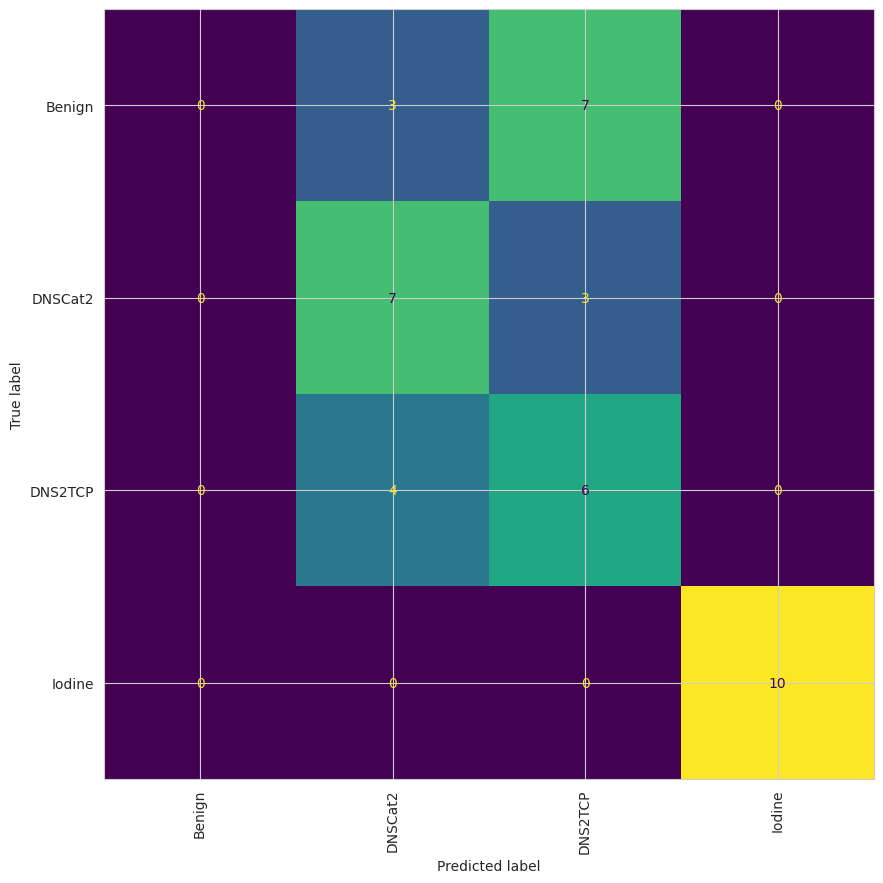

In [223]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, flow_pred, display_labels=CLASSES_LIST, xticks_rotation='vertical',
                                        ax=ax, colorbar=False)
plt.savefig(output_dir / 'ConfusionMatrix.pdf', bbox_inches="tight")

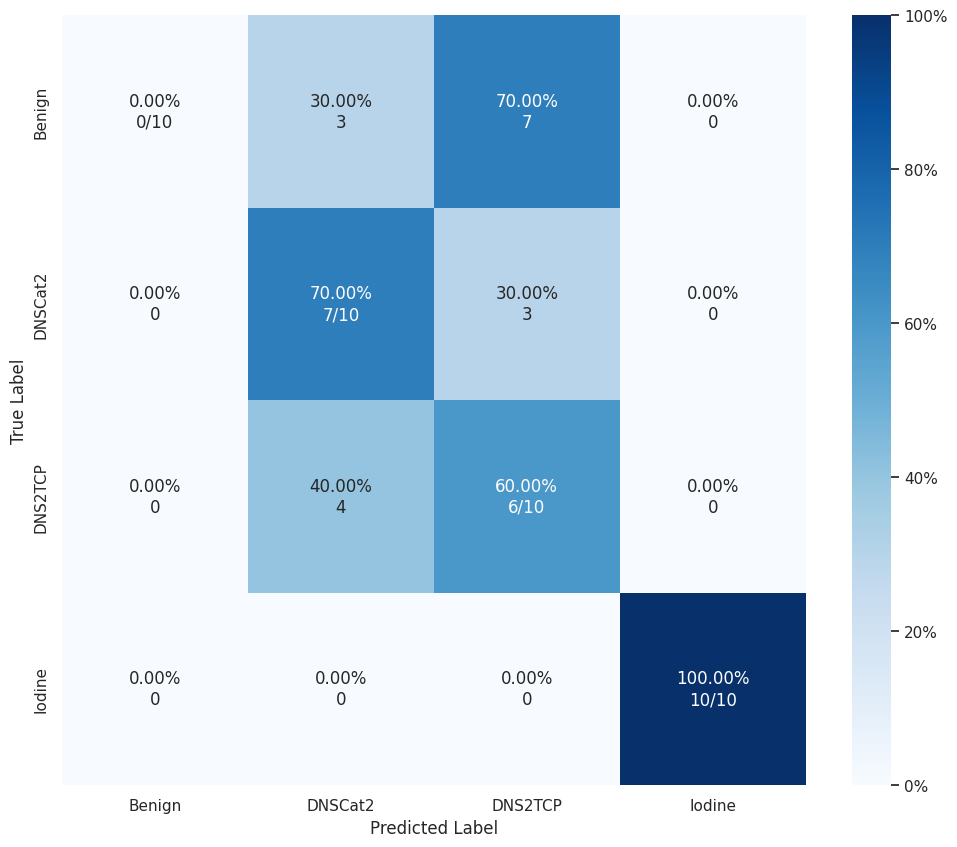

In [224]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17, 17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s[0])
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format': PercentFormatter()},
                yticklabels=classes, cmap="Blues")
    plt.savefig(filename, bbox_inches='tight')


cm_analysis(y_true=y_test, y_pred=flow_pred, filename=output_dir / 'ConfusionMatrix_nom.pdf', labels=[0, 1, 2, 3],
            classes=CLASSES_LIST, figsize=(12, 10))

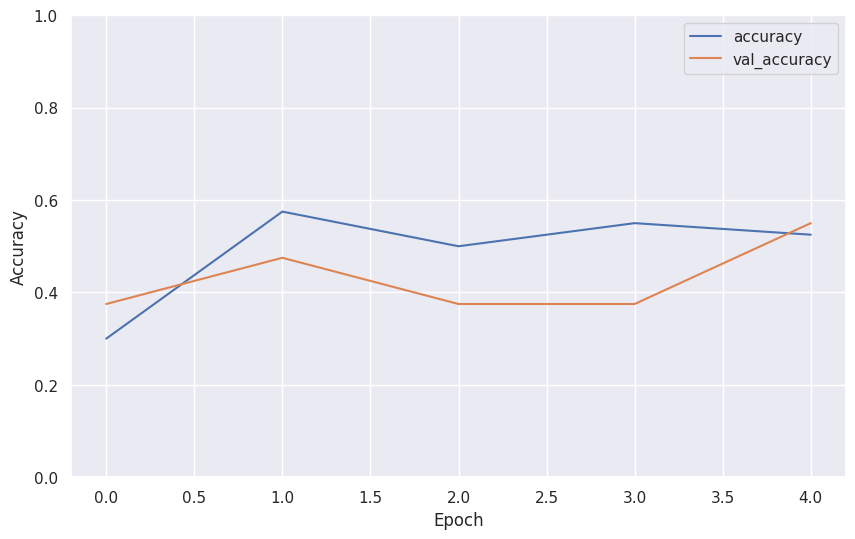

In [225]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(
    history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.savefig(output_dir / "normal_model_Accuracy.pdf")

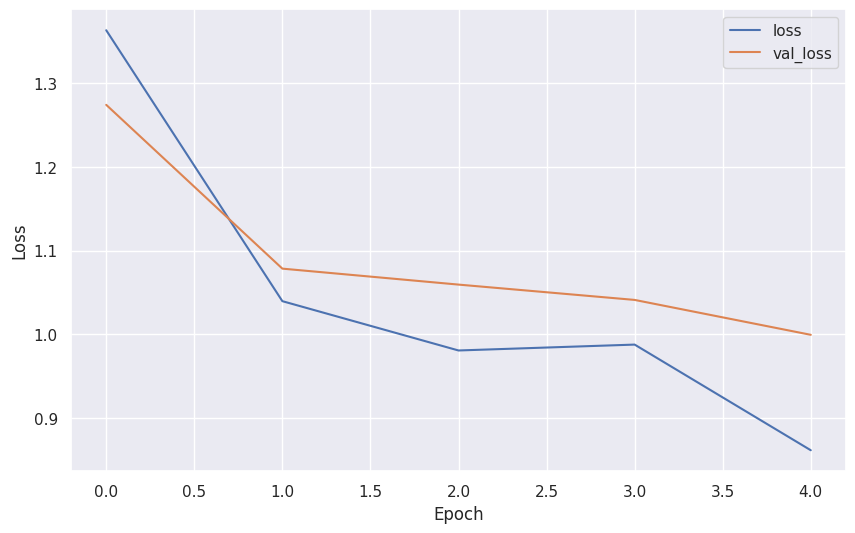

In [226]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig(output_dir / "normal_model_Loss.pdf")
